# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float64) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float64) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [4]:
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [5]:
probs_1 = linear_classifer.softmax(np.array([-10, 0, 10]))
probs_2 = linear_classifer.softmax(np.array([[-10, 0, 10], [-10, 0, 10]]))
assert np.isclose(probs_2[0], probs_2[1]).all()
assert np.isclose(probs_1, probs_2[0]).all()

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [6]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
res_1 = linear_classifer.cross_entropy_loss(probs, 1)

probs = linear_classifer.softmax(np.array([[-5, 0, 5],[-5, 0, 5]]))
res_2 = linear_classifer.cross_entropy_loss(probs, [1, 1])

assert np.isclose(2 * res_1, res_2)

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращать и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [7]:
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float64))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [8]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float64)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int64)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float64)
target_index = np.random.randint(0, num_classes, size=(batch_size,)).astype(np.int64)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [9]:
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float64)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float64)
target_index = np.ones(batch_size, dtype=np.int64)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [10]:
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [11]:
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 906.871488
Epoch 1, loss: 825.584396
Epoch 2, loss: 902.878919
Epoch 3, loss: 827.797725
Epoch 4, loss: 941.842498
Epoch 5, loss: 880.560739
Epoch 6, loss: 943.678888
Epoch 7, loss: 1026.815970
Epoch 8, loss: 930.278042
Epoch 9, loss: 825.024273


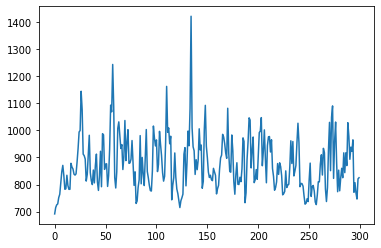

In [12]:
# let's look at the loss history!
plt.plot(loss_history)

In [13]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.15
Epoch 0, loss: 957.189762
Epoch 1, loss: 762.027763
Epoch 2, loss: 1013.551767
Epoch 3, loss: 868.116091
Epoch 4, loss: 981.570356
Epoch 5, loss: 788.059239
Epoch 6, loss: 729.206386
Epoch 7, loss: 899.788571
Epoch 8, loss: 837.287123
Epoch 9, loss: 853.893548
Epoch 10, loss: 841.143150
Epoch 11, loss: 885.058522
Epoch 12, loss: 965.588203
Epoch 13, loss: 1018.778235
Epoch 14, loss: 872.091154
Epoch 15, loss: 794.062402
Epoch 16, loss: 915.532136
Epoch 17, loss: 771.000433
Epoch 18, loss: 905.495419
Epoch 19, loss: 833.892578
Epoch 20, loss: 793.159365
Epoch 21, loss: 948.230873
Epoch 22, loss: 802.878819
Epoch 23, loss: 837.342769
Epoch 24, loss: 718.399957
Epoch 25, loss: 927.593383
Epoch 26, loss: 925.025384
Epoch 27, loss: 872.038063
Epoch 28, loss: 992.068556
Epoch 29, loss: 899.115332
Epoch 30, loss: 735.089290
Epoch 31, loss: 1060.146331
Epoch 32, loss: 883.165548
Epoch 33, loss: 856.359529
Epoch 34, loss: 904.379355
Epoch 35, loss: 874.913416
Epoch 36, loss: 817

### Как и раньше, используем кросс-валидацию для подбора гиперпараметров.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [14]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-7]
reg_strengths = [1e-4, 1e-5, 1e-6, 1e-7]

best_classifier = None
best_val_accuracy = 0

for lr in learning_rates:
    for reg in reg_strengths:
        print(f'lr = {lr}, reg = {reg}')
        classifier = linear_classifer.LinearSoftmaxClassifier()
        _ = classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=lr, batch_size=batch_size, reg=reg)
        
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            best_hyperparameters = (lr, reg)
            best_classifier = classifier
        

print('best validation accuracy achieved: %f' % best_val_accuracy)
lr, reg = best_hyperparameters
print(f'best hyperparameters: lr = {lr}, reg = {reg}')

lr = 0.01, reg = 0.0001
Epoch 0, loss: 6047.913103
Epoch 1, loss: 6316.712129
Epoch 2, loss: 5413.061678
Epoch 3, loss: 5448.101884
Epoch 4, loss: 5527.281401
Epoch 5, loss: 5300.972399
Epoch 6, loss: 6776.033473
Epoch 7, loss: 6684.881834
Epoch 8, loss: 5970.477533
Epoch 9, loss: 5465.138923
Epoch 10, loss: 5947.765496
Epoch 11, loss: 5880.498968
Epoch 12, loss: 6455.065959
Epoch 13, loss: 5692.029515
Epoch 14, loss: 5977.060020
Epoch 15, loss: 5863.006218
Epoch 16, loss: 6137.535600
Epoch 17, loss: 5323.458421
Epoch 18, loss: 6947.121270
Epoch 19, loss: 5871.229919
Epoch 20, loss: 6435.700596
Epoch 21, loss: 4244.482415
Epoch 22, loss: 6831.468625
Epoch 23, loss: 6999.186165
Epoch 24, loss: 5907.000990
Epoch 25, loss: 5817.634294
Epoch 26, loss: 7246.925030
Epoch 27, loss: 6831.613212
Epoch 28, loss: 4416.735654
Epoch 29, loss: 6916.973624
Epoch 30, loss: 6847.169717
Epoch 31, loss: 5539.644739
Epoch 32, loss: 4665.079085
Epoch 33, loss: 6148.735918
Epoch 34, loss: 6030.547469
Epoch 

Epoch 89, loss: 6432.955780
Epoch 90, loss: 5014.941624
Epoch 91, loss: 5074.720188
Epoch 92, loss: 5669.412571
Epoch 93, loss: 3900.133034
Epoch 94, loss: 4513.156616
Epoch 95, loss: 5853.241299
Epoch 96, loss: 5990.051607
Epoch 97, loss: 5375.577423
Epoch 98, loss: 5277.661786
Epoch 99, loss: 5177.371315
Epoch 100, loss: 6746.816124
Epoch 101, loss: 5845.828895
Epoch 102, loss: 6507.807462
Epoch 103, loss: 7343.314295
Epoch 104, loss: 6726.624365
Epoch 105, loss: 6129.333427
Epoch 106, loss: 6036.337563
Epoch 107, loss: 7357.212038
Epoch 108, loss: 6059.785760
Epoch 109, loss: 4808.580800
Epoch 110, loss: 5088.955670
Epoch 111, loss: 7128.623602
Epoch 112, loss: 4807.343869
Epoch 113, loss: 6158.484594
Epoch 114, loss: 5233.228794
Epoch 115, loss: 5792.008296
Epoch 116, loss: 7009.485177
Epoch 117, loss: 5470.449552
Epoch 118, loss: 4458.219435
Epoch 119, loss: 5633.381659
Epoch 120, loss: 5167.111724
Epoch 121, loss: 5817.656449
Epoch 122, loss: 5033.245609
Epoch 123, loss: 4137.865

Epoch 175, loss: 5438.191406
Epoch 176, loss: 4235.520341
Epoch 177, loss: 5075.932233
Epoch 178, loss: 5496.465703
Epoch 179, loss: 4102.444221
Epoch 180, loss: 5321.880230
Epoch 181, loss: 6742.807725
Epoch 182, loss: 5844.722476
Epoch 183, loss: 5345.008186
Epoch 184, loss: 5657.051007
Epoch 185, loss: 3937.670246
Epoch 186, loss: 4502.180177
Epoch 187, loss: 5784.179243
Epoch 188, loss: 5563.828311
Epoch 189, loss: 4770.559918
Epoch 190, loss: 4207.679359
Epoch 191, loss: 5233.560266
Epoch 192, loss: 4863.478895
Epoch 193, loss: 5241.381268
Epoch 194, loss: 5346.649918
Epoch 195, loss: 5863.801825
Epoch 196, loss: 5872.680253
Epoch 197, loss: 5331.799558
Epoch 198, loss: 4696.086496
Epoch 199, loss: 4755.062821
lr = 0.01, reg = 1e-07
Epoch 0, loss: 5664.706536
Epoch 1, loss: 6354.172488
Epoch 2, loss: 4611.099973
Epoch 3, loss: 6676.347005
Epoch 4, loss: 5711.181836
Epoch 5, loss: 5314.338745
Epoch 6, loss: 6518.093376
Epoch 7, loss: 7558.566267
Epoch 8, loss: 5632.286700
Epoch 9, 

Epoch 65, loss: 953.167002
Epoch 66, loss: 721.024117
Epoch 67, loss: 727.814289
Epoch 68, loss: 804.383971
Epoch 69, loss: 675.902580
Epoch 70, loss: 783.330752
Epoch 71, loss: 1065.339276
Epoch 72, loss: 769.465798
Epoch 73, loss: 777.921666
Epoch 74, loss: 698.379476
Epoch 75, loss: 738.190960
Epoch 76, loss: 717.595298
Epoch 77, loss: 711.985543
Epoch 78, loss: 682.487399
Epoch 79, loss: 818.171801
Epoch 80, loss: 885.973732
Epoch 81, loss: 762.942599
Epoch 82, loss: 981.425138
Epoch 83, loss: 711.086387
Epoch 84, loss: 816.461124
Epoch 85, loss: 718.454762
Epoch 86, loss: 839.493899
Epoch 87, loss: 759.730712
Epoch 88, loss: 798.211743
Epoch 89, loss: 800.832459
Epoch 90, loss: 888.402653
Epoch 91, loss: 663.246945
Epoch 92, loss: 665.087722
Epoch 93, loss: 793.493270
Epoch 94, loss: 795.011983
Epoch 95, loss: 637.148511
Epoch 96, loss: 842.878450
Epoch 97, loss: 750.116249
Epoch 98, loss: 874.778353
Epoch 99, loss: 953.447186
Epoch 100, loss: 767.759984
Epoch 101, loss: 637.63438

Epoch 163, loss: 840.269295
Epoch 164, loss: 689.876114
Epoch 165, loss: 721.846974
Epoch 166, loss: 663.279804
Epoch 167, loss: 677.095036
Epoch 168, loss: 634.155524
Epoch 169, loss: 703.641512
Epoch 170, loss: 661.861723
Epoch 171, loss: 715.267044
Epoch 172, loss: 712.563307
Epoch 173, loss: 688.968110
Epoch 174, loss: 686.124401
Epoch 175, loss: 766.506876
Epoch 176, loss: 770.310147
Epoch 177, loss: 790.997358
Epoch 178, loss: 635.345055
Epoch 179, loss: 639.584980
Epoch 180, loss: 704.750727
Epoch 181, loss: 810.813095
Epoch 182, loss: 807.593620
Epoch 183, loss: 839.694372
Epoch 184, loss: 759.738142
Epoch 185, loss: 663.088801
Epoch 186, loss: 649.315130
Epoch 187, loss: 748.257377
Epoch 188, loss: 650.909504
Epoch 189, loss: 646.269507
Epoch 190, loss: 871.173903
Epoch 191, loss: 683.895144
Epoch 192, loss: 930.223225
Epoch 193, loss: 770.394773
Epoch 194, loss: 687.907707
Epoch 195, loss: 693.700392
Epoch 196, loss: 686.643593
Epoch 197, loss: 746.956745
Epoch 198, loss: 615

Epoch 61, loss: 651.399202
Epoch 62, loss: 731.167210
Epoch 63, loss: 615.803783
Epoch 64, loss: 796.530382
Epoch 65, loss: 686.734219
Epoch 66, loss: 735.463433
Epoch 67, loss: 745.072841
Epoch 68, loss: 849.103529
Epoch 69, loss: 771.223568
Epoch 70, loss: 733.290752
Epoch 71, loss: 699.020344
Epoch 72, loss: 1088.977910
Epoch 73, loss: 672.313650
Epoch 74, loss: 736.113673
Epoch 75, loss: 782.317814
Epoch 76, loss: 840.728824
Epoch 77, loss: 777.592510
Epoch 78, loss: 928.720175
Epoch 79, loss: 714.690472
Epoch 80, loss: 712.259602
Epoch 81, loss: 700.875693
Epoch 82, loss: 802.926952
Epoch 83, loss: 712.094742
Epoch 84, loss: 663.544090
Epoch 85, loss: 643.010124
Epoch 86, loss: 848.267728
Epoch 87, loss: 689.091303
Epoch 88, loss: 843.917474
Epoch 89, loss: 606.112070
Epoch 90, loss: 676.183444
Epoch 91, loss: 712.966208
Epoch 92, loss: 682.045873
Epoch 93, loss: 827.650022
Epoch 94, loss: 787.223816
Epoch 95, loss: 640.149939
Epoch 96, loss: 653.643018
Epoch 97, loss: 745.575755


Epoch 159, loss: 620.394245
Epoch 160, loss: 637.790840
Epoch 161, loss: 613.531425
Epoch 162, loss: 614.802560
Epoch 163, loss: 602.145098
Epoch 164, loss: 624.172835
Epoch 165, loss: 622.581967
Epoch 166, loss: 625.795772
Epoch 167, loss: 612.235743
Epoch 168, loss: 616.333454
Epoch 169, loss: 608.302339
Epoch 170, loss: 616.860524
Epoch 171, loss: 606.464987
Epoch 172, loss: 622.472316
Epoch 173, loss: 618.322941
Epoch 174, loss: 617.755053
Epoch 175, loss: 631.936254
Epoch 176, loss: 620.084080
Epoch 177, loss: 622.217108
Epoch 178, loss: 604.101613
Epoch 179, loss: 622.718349
Epoch 180, loss: 607.053756
Epoch 181, loss: 621.380825
Epoch 182, loss: 607.770142
Epoch 183, loss: 629.007683
Epoch 184, loss: 619.392413
Epoch 185, loss: 604.184609
Epoch 186, loss: 603.475860
Epoch 187, loss: 628.138843
Epoch 188, loss: 627.657660
Epoch 189, loss: 622.098691
Epoch 190, loss: 609.863620
Epoch 191, loss: 617.134067
Epoch 192, loss: 627.491407
Epoch 193, loss: 631.091760
Epoch 194, loss: 607

Epoch 57, loss: 638.460508
Epoch 58, loss: 642.947419
Epoch 59, loss: 631.528152
Epoch 60, loss: 636.345221
Epoch 61, loss: 642.656765
Epoch 62, loss: 638.531892
Epoch 63, loss: 627.996409
Epoch 64, loss: 635.482655
Epoch 65, loss: 633.673221
Epoch 66, loss: 623.666829
Epoch 67, loss: 639.181069
Epoch 68, loss: 619.219844
Epoch 69, loss: 634.189331
Epoch 70, loss: 641.058835
Epoch 71, loss: 622.728813
Epoch 72, loss: 634.780942
Epoch 73, loss: 648.910341
Epoch 74, loss: 638.399671
Epoch 75, loss: 627.131083
Epoch 76, loss: 649.447370
Epoch 77, loss: 614.005559
Epoch 78, loss: 634.599045
Epoch 79, loss: 642.605766
Epoch 80, loss: 636.047253
Epoch 81, loss: 621.284740
Epoch 82, loss: 630.858355
Epoch 83, loss: 604.050884
Epoch 84, loss: 621.047251
Epoch 85, loss: 612.194298
Epoch 86, loss: 623.842193
Epoch 87, loss: 620.821702
Epoch 88, loss: 620.735746
Epoch 89, loss: 629.276470
Epoch 90, loss: 627.694575
Epoch 91, loss: 608.338846
Epoch 92, loss: 634.264950
Epoch 93, loss: 617.515322
E

Epoch 155, loss: 629.772007
Epoch 156, loss: 638.112836
Epoch 157, loss: 627.136288
Epoch 158, loss: 619.948384
Epoch 159, loss: 624.120357
Epoch 160, loss: 618.807957
Epoch 161, loss: 612.747913
Epoch 162, loss: 619.805659
Epoch 163, loss: 622.378884
Epoch 164, loss: 613.572096
Epoch 165, loss: 611.981669
Epoch 166, loss: 622.090902
Epoch 167, loss: 602.978191
Epoch 168, loss: 617.157968
Epoch 169, loss: 621.097634
Epoch 170, loss: 604.331022
Epoch 171, loss: 622.881733
Epoch 172, loss: 629.169637
Epoch 173, loss: 624.581152
Epoch 174, loss: 610.353708
Epoch 175, loss: 623.873837
Epoch 176, loss: 634.484055
Epoch 177, loss: 624.932821
Epoch 178, loss: 629.277618
Epoch 179, loss: 621.912946
Epoch 180, loss: 612.573445
Epoch 181, loss: 611.025112
Epoch 182, loss: 599.923169
Epoch 183, loss: 614.292143
Epoch 184, loss: 628.351231
Epoch 185, loss: 617.284637
Epoch 186, loss: 610.759430
Epoch 187, loss: 608.740667
Epoch 188, loss: 640.339170
Epoch 189, loss: 612.613838
Epoch 190, loss: 619

Epoch 53, loss: 657.165370
Epoch 54, loss: 668.765380
Epoch 55, loss: 658.345831
Epoch 56, loss: 656.917695
Epoch 57, loss: 669.173445
Epoch 58, loss: 660.552512
Epoch 59, loss: 666.183580
Epoch 60, loss: 665.680956
Epoch 61, loss: 663.305066
Epoch 62, loss: 665.346440
Epoch 63, loss: 669.033484
Epoch 64, loss: 660.410880
Epoch 65, loss: 655.067411
Epoch 66, loss: 659.923617
Epoch 67, loss: 666.998872
Epoch 68, loss: 662.226617
Epoch 69, loss: 664.780275
Epoch 70, loss: 655.715076
Epoch 71, loss: 651.157112
Epoch 72, loss: 661.509955
Epoch 73, loss: 659.301719
Epoch 74, loss: 658.670592
Epoch 75, loss: 656.308830
Epoch 76, loss: 661.406943
Epoch 77, loss: 653.495118
Epoch 78, loss: 661.810741
Epoch 79, loss: 662.458982
Epoch 80, loss: 663.052928
Epoch 81, loss: 654.610946
Epoch 82, loss: 658.745628
Epoch 83, loss: 656.398057
Epoch 84, loss: 656.770171
Epoch 85, loss: 658.602779
Epoch 86, loss: 659.290582
Epoch 87, loss: 653.949267
Epoch 88, loss: 651.592696
Epoch 89, loss: 660.666291
E

Epoch 151, loss: 637.578069
Epoch 152, loss: 650.485219
Epoch 153, loss: 651.628304
Epoch 154, loss: 657.622621
Epoch 155, loss: 642.624507
Epoch 156, loss: 636.934705
Epoch 157, loss: 653.943573
Epoch 158, loss: 647.370793
Epoch 159, loss: 647.025239
Epoch 160, loss: 654.649350
Epoch 161, loss: 649.012011
Epoch 162, loss: 648.800754
Epoch 163, loss: 648.523489
Epoch 164, loss: 640.498587
Epoch 165, loss: 636.667846
Epoch 166, loss: 647.239394
Epoch 167, loss: 640.276972
Epoch 168, loss: 660.813529
Epoch 169, loss: 641.525973
Epoch 170, loss: 641.853196
Epoch 171, loss: 629.551011
Epoch 172, loss: 637.683705
Epoch 173, loss: 634.859878
Epoch 174, loss: 643.356032
Epoch 175, loss: 658.444089
Epoch 176, loss: 647.374300
Epoch 177, loss: 648.465277
Epoch 178, loss: 637.411441
Epoch 179, loss: 645.339896
Epoch 180, loss: 647.797932
Epoch 181, loss: 645.940142
Epoch 182, loss: 663.849168
Epoch 183, loss: 643.603272
Epoch 184, loss: 646.983267
Epoch 185, loss: 643.969990
Epoch 186, loss: 654

Epoch 49, loss: 690.276224
Epoch 50, loss: 690.456160
Epoch 51, loss: 690.170199
Epoch 52, loss: 690.541578
Epoch 53, loss: 690.150138
Epoch 54, loss: 690.298109
Epoch 55, loss: 690.091693
Epoch 56, loss: 690.044034
Epoch 57, loss: 690.049788
Epoch 58, loss: 690.165084
Epoch 59, loss: 690.209433
Epoch 60, loss: 690.227103
Epoch 61, loss: 690.298711
Epoch 62, loss: 689.855449
Epoch 63, loss: 689.840993
Epoch 64, loss: 689.731911
Epoch 65, loss: 689.848504
Epoch 66, loss: 690.304367
Epoch 67, loss: 689.933174
Epoch 68, loss: 690.149975
Epoch 69, loss: 690.059246
Epoch 70, loss: 690.214627
Epoch 71, loss: 689.834070
Epoch 72, loss: 689.756697
Epoch 73, loss: 689.981626
Epoch 74, loss: 690.111702
Epoch 75, loss: 689.784340
Epoch 76, loss: 690.038277
Epoch 77, loss: 690.027378
Epoch 78, loss: 689.865460
Epoch 79, loss: 690.077484
Epoch 80, loss: 689.800269
Epoch 81, loss: 690.454355
Epoch 82, loss: 689.867874
Epoch 83, loss: 690.249387
Epoch 84, loss: 690.156315
Epoch 85, loss: 689.683980
E

Epoch 147, loss: 689.716624
Epoch 148, loss: 689.603599
Epoch 149, loss: 689.290977
Epoch 150, loss: 689.255727
Epoch 151, loss: 689.485910
Epoch 152, loss: 689.121529
Epoch 153, loss: 689.632307
Epoch 154, loss: 689.036096
Epoch 155, loss: 688.421728
Epoch 156, loss: 689.592388
Epoch 157, loss: 689.050017
Epoch 158, loss: 689.610973
Epoch 159, loss: 689.372651
Epoch 160, loss: 688.735315
Epoch 161, loss: 690.031713
Epoch 162, loss: 689.292206
Epoch 163, loss: 688.896484
Epoch 164, loss: 689.291975
Epoch 165, loss: 689.174225
Epoch 166, loss: 689.149650
Epoch 167, loss: 689.094756
Epoch 168, loss: 689.488569
Epoch 169, loss: 688.890596
Epoch 170, loss: 689.329636
Epoch 171, loss: 689.338064
Epoch 172, loss: 690.075059
Epoch 173, loss: 688.605995
Epoch 174, loss: 689.249928
Epoch 175, loss: 689.649501
Epoch 176, loss: 689.608593
Epoch 177, loss: 689.851006
Epoch 178, loss: 689.350765
Epoch 179, loss: 689.167054
Epoch 180, loss: 688.686258
Epoch 181, loss: 690.190168
Epoch 182, loss: 689

Epoch 45, loss: 690.440804
Epoch 46, loss: 690.419195
Epoch 47, loss: 690.476572
Epoch 48, loss: 690.026503
Epoch 49, loss: 690.324527
Epoch 50, loss: 690.266525
Epoch 51, loss: 690.394869
Epoch 52, loss: 690.486285
Epoch 53, loss: 690.417991
Epoch 54, loss: 690.180040
Epoch 55, loss: 690.441362
Epoch 56, loss: 690.142157
Epoch 57, loss: 689.841861
Epoch 58, loss: 690.861423
Epoch 59, loss: 690.060204
Epoch 60, loss: 690.288477
Epoch 61, loss: 689.524668
Epoch 62, loss: 690.337413
Epoch 63, loss: 689.707259
Epoch 64, loss: 689.964554
Epoch 65, loss: 689.845165
Epoch 66, loss: 690.193959
Epoch 67, loss: 690.182052
Epoch 68, loss: 690.116746
Epoch 69, loss: 690.423097
Epoch 70, loss: 689.628691
Epoch 71, loss: 689.948497
Epoch 72, loss: 690.067952
Epoch 73, loss: 690.276160
Epoch 74, loss: 690.155041
Epoch 75, loss: 690.079882
Epoch 76, loss: 690.219104
Epoch 77, loss: 689.984034
Epoch 78, loss: 689.703438
Epoch 79, loss: 689.823335
Epoch 80, loss: 690.153023
Epoch 81, loss: 689.879291
E

# Какой же точности мы добились на тестовых данных?

In [15]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.210000
